# Verifying beam expansion in a drift in Synergia

This is an updated notebook which provides benchmarks for beam expansion in a drift (with/without space charge) for the purposes of testing the rsrespic code. This notebook was originally built to validate Synergia's space charge solver, but has been updated to permit more flexible bunch generation using the [bunch](https://github.com/radiasoft/rsbeams/blob/master/rsbeams/rsptcls/bunch.py) module in rsbeams

### RS Respic Parameters

1. 2 GeV kinetic energy
3. 10 cm bunch length
2. 10 nC/cm charge per length
3. sigmax = 2 mm
4. emittance = 4 micron (un normalized)

The total bunch charge is then 100 nC, and the beam current is roughly

$$I = \beta c \frac {Q}{L} \approx 284 \mathrm{A}$$

The initial transverse particle distribution is assumed to be Gaussian, but the means of making it KV are demonstrated as well. The initial longitudinal particle distribution is assumed to be uniform in position (z), with zero energy spread. For a 2D solver the longitudinal distribution is irrelevant.

Synergia's self-consistent 2D PIC algorithm is used by default. However, Synergia also provides a semi-analytic model based on the Bassetti-Erskine 2D formula. This is a "frozen" space charge algorithm, which assumes the transverse particle distribution is Gaussian in position and momentum.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import tables
from mpi4py import MPI

from rsbeams.rsptcls import bunch

### Import physics libraries

In [2]:
try:
    import rssynergia
except ImportError:
    !pip -q install git+git://github.com/radiasoft/rssynergia

from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.base_diagnostics import diagplot
from rssynergia.base_diagnostics import utils

from rssynergia.elliptic import elliptic_beam6d
from rssynergia.standard import standard_beam6d

import synergia
import synergia_workflow

#Relevant Constants
clight = synergia.foundation.pconstants.c
e = synergia.foundation.pconstants.e

### Test problem - Expanding beam in a drift

Beam Parameters:
1. 2 GeV kinetic energy
3. 10 cm bunch length
2. 10 nC/cm charge per length (100 nC total charge)
3. sigmax = 2 mm
4. emittance = 4 micron (un normalized)

Grid/Domain Parameters:
- 50000 macro-particles
- 64x64 mesh (2D Open)
- 100 "turns" at 0.01 m drift length

### Specify Synergia simulation options (default values)

I'm selecting to change these within the notebook instead of using a separate file. This code block could be transferred to the "SC_test_options.py" file if preferred.

In [3]:
#Specify user-defined beam parameters
L_BUNCH = 0.1 # 10 cm bunch length
Q_BUNCH = 100e-9 #100 nC bunch
E_KINETIC = 2.0 #GeV
N_BUNCH = Q_BUNCH/e#number of protons

# Create and populate a Synergia options object
# File I/O
opts = synergia_workflow.Options("zc_drift")
opts.add("output_dir","sc_drift", "Directory for output files", str)
opts.relpath = opts.output_dir
workflow.make_path(opts.output_dir)
opts.add("verbosity", 1, "Verbosity of propagation", int)
opts.add("bunch_file","myBunch.txt","txt file for bunch particles", str)

# Define reference particle to be a proton with specified kinetic energy
total_energy = synergia.foundation.pconstants.proton_mass + E_KINETIC  # [GeV]
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,four_momentum)
opts.gamma = reference_particle.get_gamma()
opts.beta = reference_particle.get_beta()

# beam (physical)
opts.add("emit",4.e-6, "H0 value corresponding to real sigma horizontal emittance of 0.3 mm-mrad", float)
opts.add("dpop", 0.0, "Delta-p/p spread", float)
opts.add("real_particles", N_BUNCH, "Number of real particles", float)
opts.add("emit_n",basic_calcs.calc_normalized_emittance(opts.emit,opts.beta,opts.gamma), "Normalized emittance", float)
opts.emits = [opts.emit]
opts.add("macro_particles", 50000, "Number of macro particles", int)


# Solver/Grid
opts.add("spacecharge", True, "whether space charge is on", bool)
opts.add("solver", "2dopen-hockney", "solver to use, '2dopen-hockney','3dopen-hockney', '2dbassetti-erskine'", str)
opts.add("gridx", 64, "grid points in x for solver", int)
opts.add("gridy", 64, "grid points in y for solver", int)
opts.add("gridz", 1, "grid points in z for solver", int)

# Lattice
opts.add("steps_per_element",5,"Number of steps per element", int)
opts.add("turns",100,"Number of turns", int)
opts.add("checkpointperiod", 15, "Interval for creating checkpoints", int)
opts.add("radius", 0.5, "aperture radius [m]", float)
opts.add("stepper", "splitoperator", "Simulation stepper, either 'independent','elements','splitoperator','soelements'", str)


# Compute and print current

I_BUNCH = opts.beta*clight*Q_BUNCH/L_BUNCH
print "Current is {} A".format(I_BUNCH)
print "Real number of protons: {}".format(N_BUNCH) 

Current is 284.096616471 A
Real number of protons: 6.24150934326e+11


### Construct the lattice (a simple drift)

In [4]:
# specify the drift element
#    note:  above, it is specified that 5 steps are taken per element
#           hence, the integration step size is my_drift_length / 5.
#           above, the number of "turns" is specified as 100
#           hence, the total drift length is 100.*my_drift_length
#           hence, the total number of steps in Synergia is 100*5 = 500
my_drift_length = 0.01  # [m]
drift_element = synergia.lattice.Lattice_element("drift", "drift_element")
drift_element.set_double_attribute("l", my_drift_length)

# instantiate the lattice
lattice = synergia.lattice.Lattice("test", synergia.lattice.Mad8_adaptor_map())
lattice.append(drift_element)
lattice.set_reference_particle(reference_particle)
opts.lattice = lattice

# specify the solver - defaults to 2Dopen-hockney
comm = synergia.utils.Commxx(True) #define a communicator
grid = [opts.gridx, opts.gridy, opts.gridz]
if opts.solver == '2dbassetti-erskine':
    coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
else:
    coll_operator = synergia.collective.Space_charge_2d_open_hockney(comm, grid)

# instantiate the lattice stepper and simulator
map_order = 1
stepper = synergia.simulation.Split_operator_stepper_elements(lattice, map_order,coll_operator, opts.steps_per_element)
opts.lattice_simulator = stepper.get_lattice_simulator()

In [5]:
#Cleanup any files from previous runs
try:
    os.remove('myBunch.txt')
except OSError:
    pass

files = os.listdir(opts.output_dir)
for file in files:
    if file.endswith('.h5'):
        os.remove(os.path.join(opts.output_dir,file))

files = os.listdir('.')
for file in files:
    if file.endswith('.h5'):
        os.remove(os.path.join('.',file))


## Construct the bunch

In [6]:
#Create a Gaussian bunch using the parameters specified above
npart = opts.macro_particles
newBunch = bunch.StandardBunch(npart, emitx = opts.emit, emity = opts.emit)
newBunch.set_longitudinal_coordinates()
newBunch.set_transverse_coordinates()

#Make the longitudinal profile uniform along z - NOT RELEVANT FOR 2D SPACE CHARGE
newBunch.particles[:,4] = L_BUNCH*(np.random.random(npart)-0.5) #center at 0

#Save the bunch
np.savetxt('myBunch.txt',newBunch.particles)         #write the bunch particles to a text file

#Construct it as a Synergia bunch using read_bunch
#Set the bucket length = the bunch length
myBunch = read_bunch.read_bunch(newBunch.particles, reference_particle, opts.real_particles, comm, L_BUNCH)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

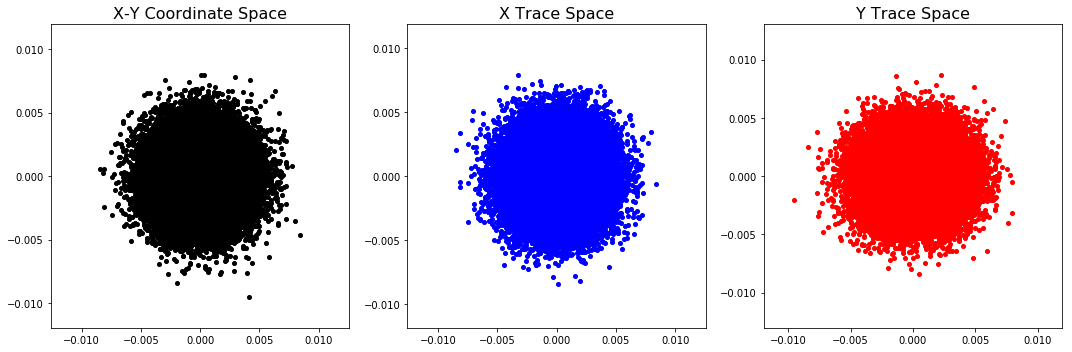

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


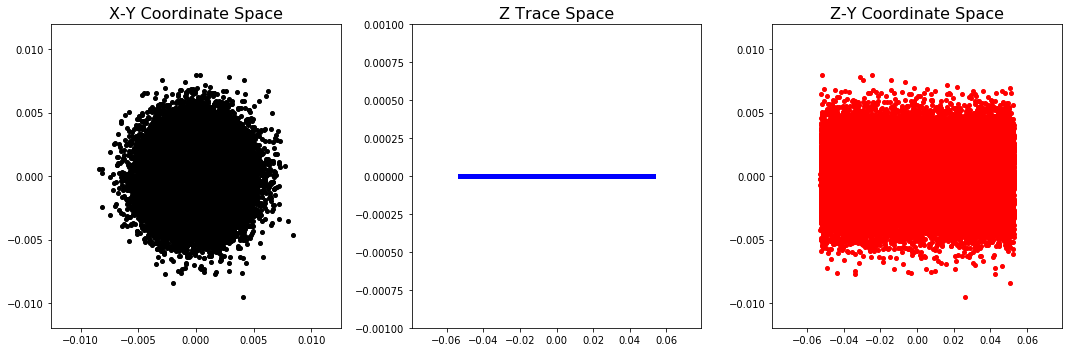

In [7]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [8]:
#Check emittance - this value is then plugged into the analytic integrator at the end of the notebook
emit = np.sqrt(np.average(local_particles[:,0]**2) * np.average(local_particles[:,1]**2) - np.average(local_particles[:,0]*local_particles[:,1])**2)
print "geometric emittance: %s \nnormalized emittance: %s" % (emit, emit * (opts.beta * opts.gamma))

geometric emittance: 3.999612791458973e-06 
normalized emittance: 1.186933897406643e-05


## Run the simulation

In [9]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [10]:
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Diagnostics

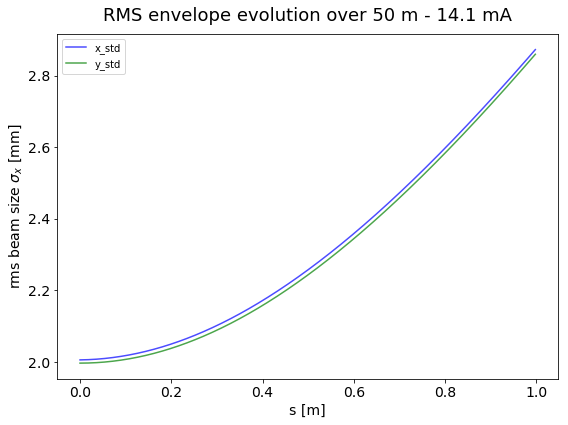

In [11]:
opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label = 'x_std') #plot x
ax.plot(xmaster,ystd*1.e3,'g-', alpha=0.7, label = 'y_std') #plot y
axtitle = "RMS envelope evolution over 50 m - 14.1 mA"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend()
sv_title = 'SC_test_envelope_10m_bunch.pdf'
fig.tight_layout()

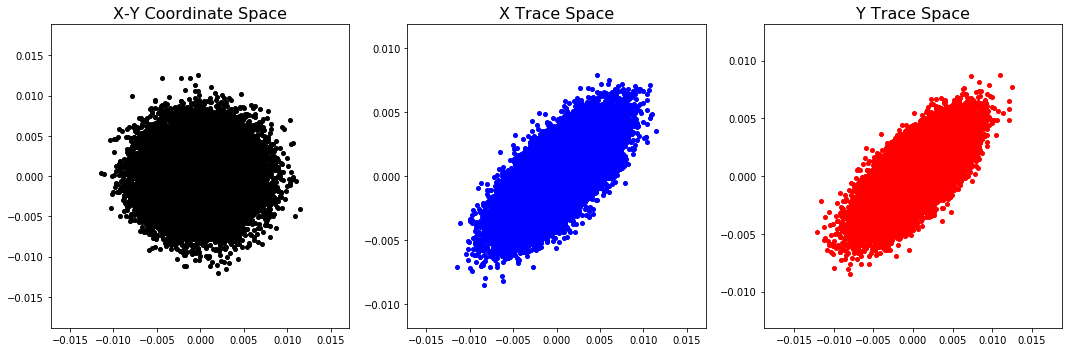

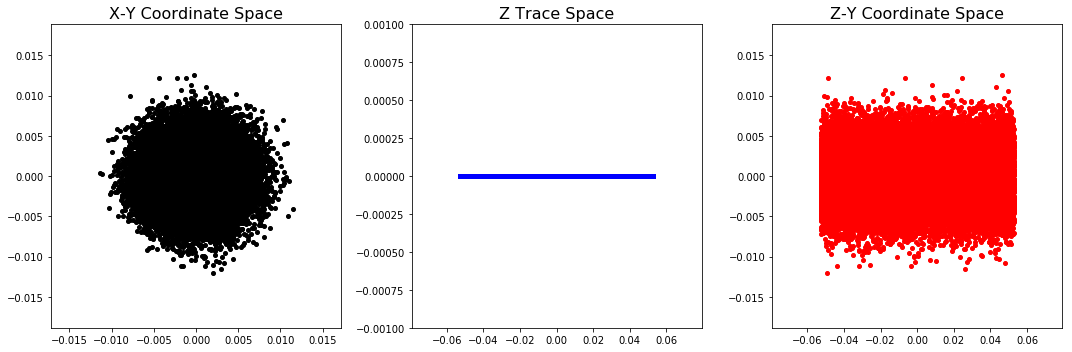

In [12]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

## Analytical Comparison

In [15]:
def calc_perveance(I,ref,cn=0):
    '''Calculate the perveance for a proton beam of a given current and particle energy.
    
    Arguments
        - I - current in A
        - ref - the reference particle for extracting beta and gamma
        
        - (optional) charge neutralization factor - default 0
    '''
    
    I0 = 3.13e7 #characteristic current
    
    beta = ref.get_beta()
    gamma = ref.get_gamma()
    
    return (I/I0)*(2/beta**3)*(1/gamma**3)

def calc_characteristic_current():
    '''Return characteristics current for proton beam'''
    return 4*np.pi*scipy.constants.epsilon_0*scipy.constants.m_p*(scipy.constants.c**3)/scipy.constants.e

In [16]:
#Introduce numerical integrators

#2nd Order RK - Ralston Method
def Ralston(r,z,h,f):
    k1 = h*f(r)
    return 0.25*k1 + 0.75*h*f(r+(2/3)*k1)

#4th Order Runge-Kutta
def RungeKutta4(r,z,h,f):
    k1 = f(r)
    k2 = f(r + (h/2)*k1)
    k3 = f(r + (h/2)*k2)
    k4 = f(r + h*k3)
    return h/6*(k1 + 2*k2 +2*k3 + k4)

#function here, which is a function of r and z
def rprime(K,emit,r0,rp0,rm):
    '''
    
    Returns the slope of the beam envelope (dr/dz) for a given value of emittance,rm, K, and initial conditions.
    
    This equation follows from Reisier.
    
    Arguments:
    
        - r - beam radius (or RMS)
        - K - perveance
        - emit - geometric emittance
        - r0 - initial envelope radius (or RMS)
        - rp0 - initial slope of envelope (or RMS)
        
    '''
    
    first = rp0**2 #first term
    second = (emit**2)*((1./r0**2)-(1./rm**2)) #second term
    third = 2*K* np.log(rm/r0) / 4
    
    return np.sqrt(first + second + third)

In [17]:
import math
from __future__ import division

def calculate_expansion(current, reference_paricle,r0,rp0,emit=emit,N=1000,zf=opts.turns * lattice.get_length()):

    '''Evaluate the expansion of a KV beam envelope in a drift along z-axis, begining at z = 0.
    
    Arguments:
        - current - beam current in A
        - reference_particle - synergia object for bunch/lattice reference particle
        - r0 - initial envelope value (provide RMS for RMS expansion, a for envelope expansion, etc.)
        - rp0 - initial slope of envelope (must be non-zero, but calculation is not sensitive to small values)
        
        - (optional) emit - geometric emittance of beam - default 2.05721258396*1.e-6 (for 0.3 mm-mrad KV beam)
        - (optional) N - number of steps for integration - default 1000
        - (optional) zf - final z value (e.g. length of expansion) - default 50.0
        
    '''
    
    z0 = 0.0 #start
    ss = (zf-z0)/N #step size

    zpoints = np.linspace(0.0, zf, num=N) #define z values
    rpoints = [] #empty array for r values
    
    #calculate perveance
    Kp = calc_perveance(current, reference_particle)
    
    #x is r
    #z is t (what we step up)
    #f is our function describing the relationship between r and z
    f = lambda r: rprime(Kp,emit,r0,rprime0,r)

    r,z,dz = r0,z0,ss
    points = []
    while z < zf:
        points.append((z,r))
        z, r = z+dz, r + Ralston(r,z,dz,f) #incremement
        
    return points

In [21]:
#Now integrate

rprime0 = 1.0*(xstd[1]-xstd[0])/(xmaster[1]-xmaster[0])
r0 = xstd[0] #1.0*1.e-3 #initial envelope value
points14 = calculate_expansion(I_BUNCH, reference_particle, r0,rprime0)
points0 = calculate_expansion(0.0, reference_particle, r0,rprime0)
print "Initial emittance used for integration is {:.2f} mm-mrad".format(emit*1e6)

Initial emittance used for integration is 4.00 mm-mrad


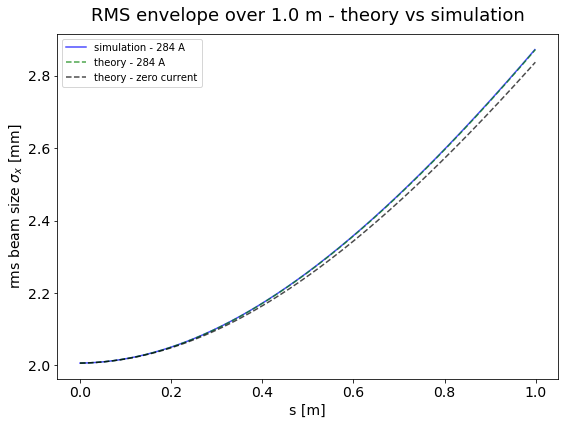

In [22]:
#Compare the results
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label = 'simulation - {:.0f} A'.format(I_BUNCH)) #plot x
ax.plot([p[0] for p in points14], [p[1]*1.e3 for p in points14],'g--',alpha=0.7, label = 'theory - {:.0f} A'.format(I_BUNCH))
ax.plot([p[0] for p in points0], [p[1]*1.e3 for p in points0],'k--',alpha=0.7, label = 'theory - zero current')
axtitle = "RMS envelope over %s m - theory vs simulation" % (opts.turns * lattice.get_length())
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc = 2)
fig.tight_layout()

## A note on alternative distributions

Creating a KV distribution is similarly straightforward with the `bunch` module. Just specify `dist = 'KV'` in the constructor.

In [24]:
#Create a Gaussian bunch using the parameters specified above
npart = opts.macro_particles
newBunch = bunch.StandardBunch(npart, dist='KV', emitx = opts.emit, emity = opts.emit)
newBunch.set_longitudinal_coordinates()
newBunch.set_transverse_coordinates()

#Make the longitudinal profile uniform along z - NOT RELEVANT FOR 2D SPACE CHARGE
newBunch.particles[:,4] = L_BUNCH*(np.random.random(npart)-0.5) #center at 0

#Save the bunch
np.savetxt('myKVBunch.txt',newBunch.particles)         #write the bunch particles to a text file

#Construct it as a Synergia bunch using read_bunch
comm = synergia.utils.Commxx(True) #define a communicator
#Set the bucket length = the bunch length
myKVBunch = read_bunch.read_bunch(newBunch.particles, reference_particle, opts.real_particles, comm, L_BUNCH)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myKVBunch.get_local_particles()
local_particles[:,4] /= opts.beta

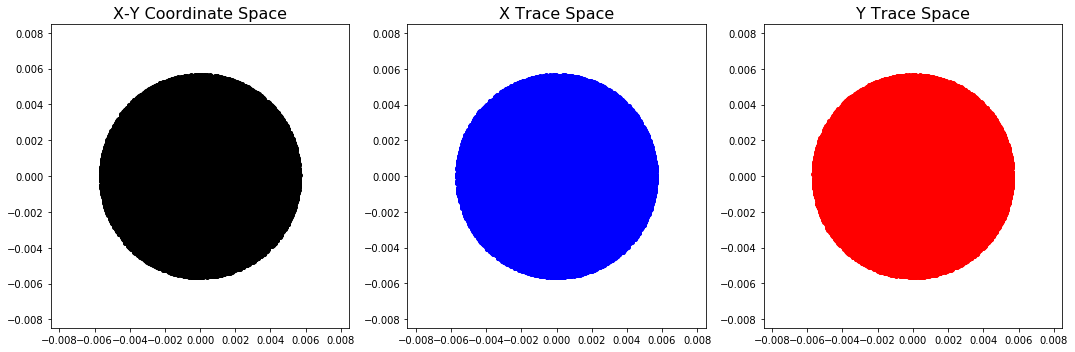

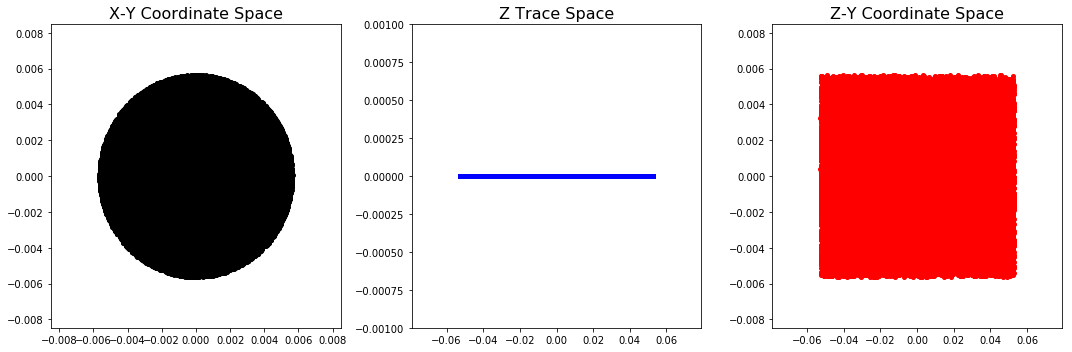

In [25]:
pltbunch.plot_bunch(myKVBunch)
pltbunch.plot_long(myKVBunch)